In [1]:
%%capture
%pip install llama-index-vector-stores-qdrant

In [2]:
%%capture

%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [3]:
%%capture
!pip install wikipedia

In [4]:
%%capture
!pip install llama-index-embeddings-clip

## Get the data from

In [1]:
from pathlib import Path
import requests

wiki_titles = [
    "Nepal",
    "China",
    "Japan"
]

data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [2]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Nepal",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

Nepal


In [12]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5",trust_remote_code=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()


In [13]:
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

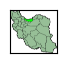

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

In [15]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

In [16]:
test_query = "What is the capital city of Nepal?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

**Node ID:** 2fdcbd7f-6775-4393-8c7f-34b7708f6f5f<br>**Similarity:** 0.8262043769978553<br>**Text:** Kathmandu, officially Kathmandu Metropolitan City, is the capital and most populous city of Nepal with 845,767 inhabitants living in 105,649 households as of the 2021 Nepal census and approximately...<br>

**Node ID:** e465bdf7-6db2-45de-bbbe-af2089590832<br>**Similarity:** 0.7946831048325544<br>**Text:** Nepal, officially the Federal Democratic Republic of Nepal, is a landlocked country in South Asia. It is mainly situated in the Himalayas, but also includes parts of the Indo-Gangetic Plain. It bor...<br>

**Node ID:** 982a6cef-d026-4248-ad2f-a7f5ff916553<br>**Similarity:** 0.7123843092203573<br>**Text:** == Geography ==

Nepal is of roughly trapezoidal shape, about 800 kilometres (500 mi) long and 200 kilometres (120 mi) wide, with an area of 147,516 km2 (56,956 sq mi). It lies between latitudes 26...<br>

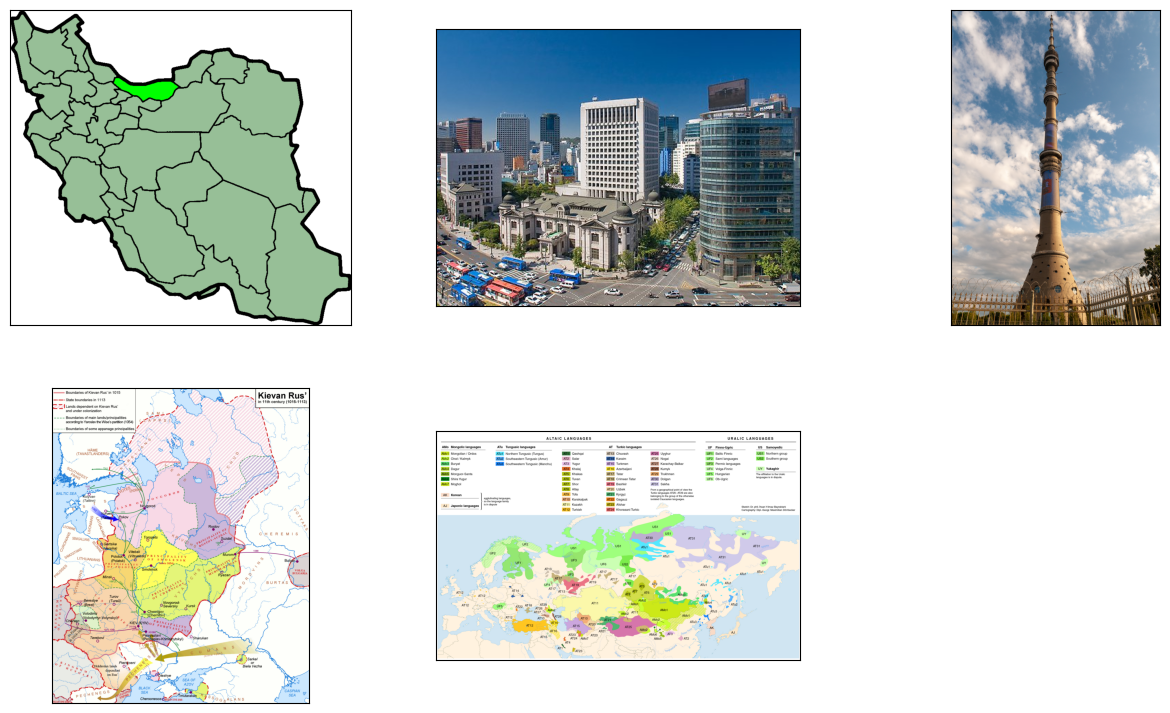

In [17]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** e465bdf7-6db2-45de-bbbe-af2089590832<br>**Similarity:** 0.7334050653810938<br>**Text:** Nepal, officially the Federal Democratic Republic of Nepal, is a landlocked country in South Asia. It is mainly situated in the Himalayas, but also includes parts of the Indo-Gangetic Plain. It bor...<br>

**Node ID:** 2fdcbd7f-6775-4393-8c7f-34b7708f6f5f<br>**Similarity:** 0.7291520775357652<br>**Text:** Kathmandu, officially Kathmandu Metropolitan City, is the capital and most populous city of Nepal with 845,767 inhabitants living in 105,649 households as of the 2021 Nepal census and approximately...<br>

**Node ID:** a10057a7-5cdd-4fb3-b4ea-392f75dad1d2<br>**Similarity:** 0.7241804732670104<br>**Text:** === Tourism ===
 Tourism is considered another important industry in Nepal. This industry started around 1950, as the country's political makeup changed and ended the country's isolation from the r...<br>

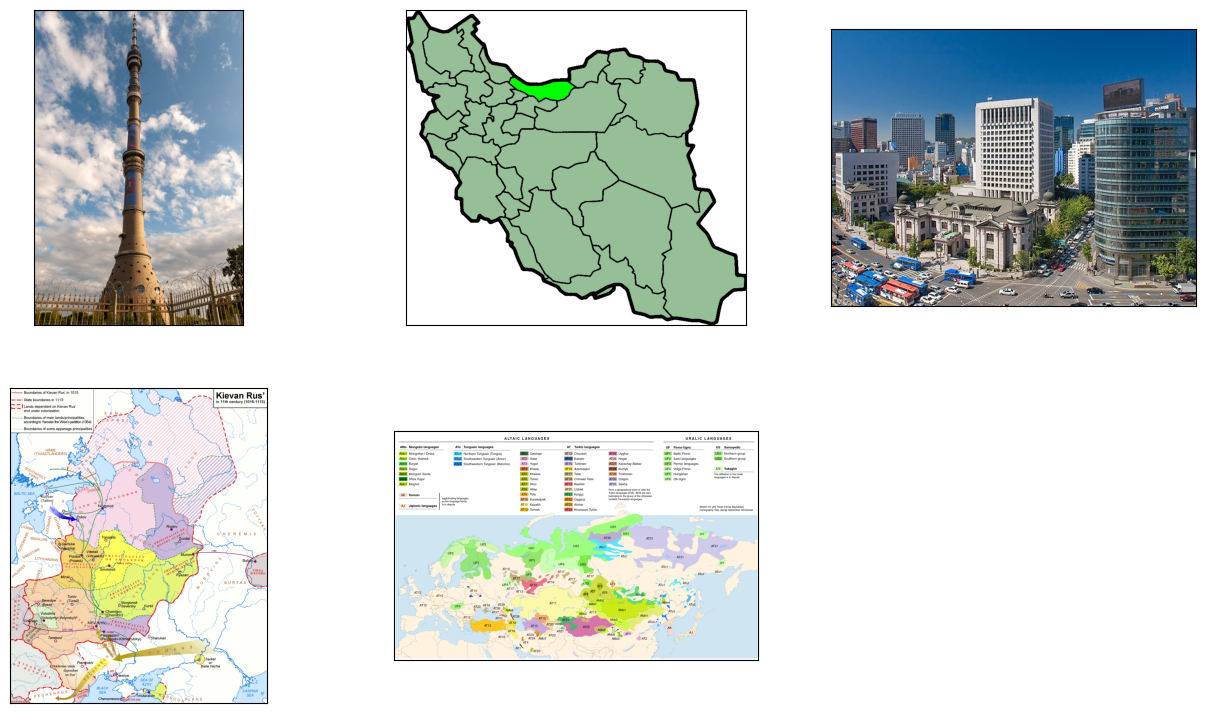

In [18]:
test_query = "what are the famous tourist destinations of Nepal?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 2fdcbd7f-6775-4393-8c7f-34b7708f6f5f<br>**Similarity:** 0.7245032208037328<br>**Text:** Kathmandu, officially Kathmandu Metropolitan City, is the capital and most populous city of Nepal with 845,767 inhabitants living in 105,649 households as of the 2021 Nepal census and approximately...<br>

**Node ID:** 11d3e292-4a44-4d40-8ec9-42d7a8009fc5<br>**Similarity:** 0.7110503191761166<br>**Text:** === Swayambhu ===

Swayambhunath (Nepali: स्वयम्भू स्तूप) is a Buddhist stupa atop a hillock at the northwestern part of the city. This is among the oldest religious sites in Nepal. Although the si...<br>

**Node ID:** e465bdf7-6db2-45de-bbbe-af2089590832<br>**Similarity:** 0.706712812949511<br>**Text:** Nepal, officially the Federal Democratic Republic of Nepal, is a landlocked country in South Asia. It is mainly situated in the Himalayas, but also includes parts of the Indo-Gangetic Plain. It bor...<br>

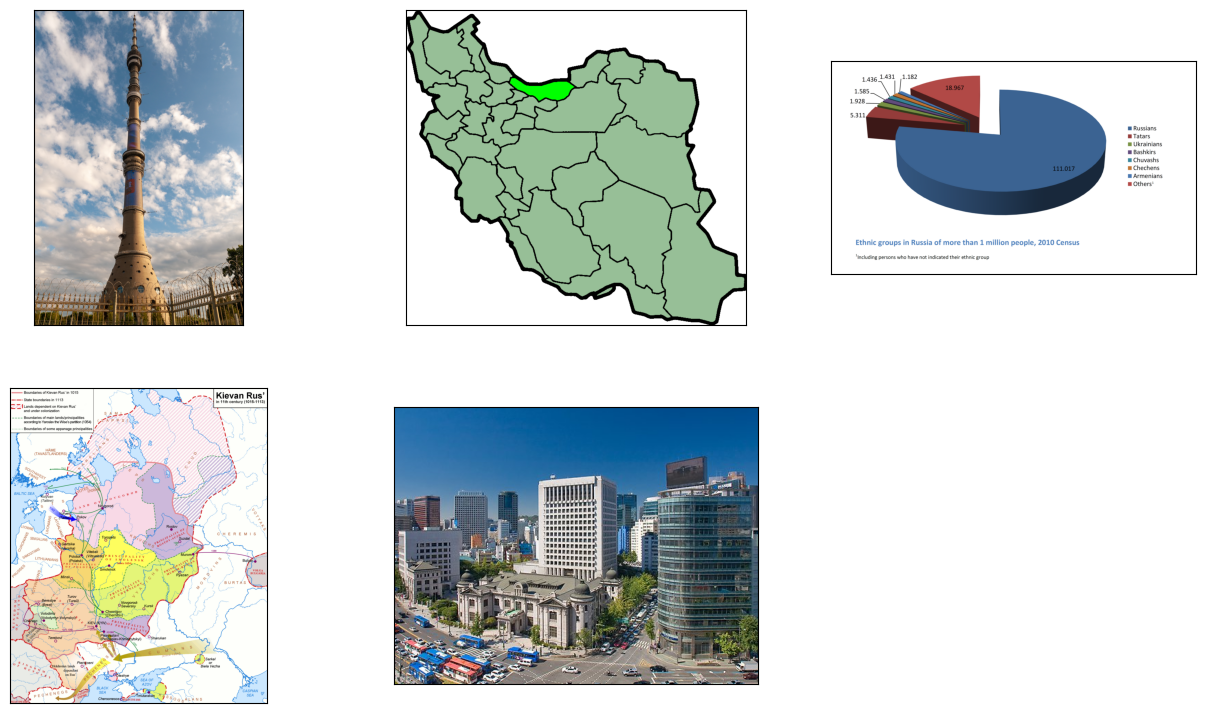

In [19]:
test_query = "what is the popular tourist attraction in western part of Nepal?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)